# Fine Tuning Roberta for Sentiment Analysis





In [ ]:
!pip install transformers
!pip install comet_ml

In [2]:
def set_experiment(api_key, project_name, workspace):
    experiment = Experiment(
    api_key=api_key,
    project_name=project_name,
    workspace=workspace
)
    
    return experiment

In [ ]:
import comet_ml
from comet_ml import Experiment

api_key = xxx
project_name = xxx
workspace = xxx

experiment = set_experiment(api_key, project_name, workspace)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy

import tqdm
import torch
import transformers
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer

In [5]:
import regex as re

In [6]:
def log_parameters(experiment, hyper_params):
    experiment.log_parameter("train_batch_size", hyper_params['batch_size'])
    experiment.log_parameter("test_batch_size", hyper_params['batch_size'])

    experiment.log_parameter("Learning Rate", hyper_params['lr'])
    experiment.log_parameter("general_epochs", hyper_params['epochs'])
    experiment.log_parameter("lr_decay", hyper_params['lr_decay'])
    experiment.log_parameter("max_len", hyper_params['max_len'])

In [7]:
X_train = pd.read_csv('train2.csv', header=0)
X_dev = pd.read_csv('dev2.csv', header=0)
X_test = pd.read_csv('test2.csv', header=0)

In [8]:
X_train['Text'] = X_train["Text"].str.lower()
X_dev['Text'] = X_dev["Text"].str.lower()
X_test['Text'] =X_test["Text"].str.lower()

In [9]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    per_pattern = re.compile(r'@[^\s]+')
    return per_pattern.sub(r'', url_pattern.sub(r'', text))

X_train['Text'] = [remove_urls(i) for i in X_train['Text']]
X_dev['Text'] = [remove_urls(i) for i in X_dev['Text']]
X_test['Text'] = [remove_urls(i) for i in X_test['Text']]

In [10]:
EMOTICONS = {
    u":‑\)":"улыбка",
    u":\)":"улыбка",
    u":-\]":"улыбка",
    u":\]":"улыбка",
    u":-3":"улыбка",
    u":3":"улыбка",
    u":->":"улыбка",
    u":>":"улыбка",
    u"8-\)":"улыбка",
    u":o":"удивление",
    u":о":"удивление",
    u":-\}":"улыбка",
    u":\}":"улыбка",
    u":-\)":"улыбка",
    u":c":"грустно",
    u":с":"грустно",
    u":\)":"улыбка",
    u":\^\)":"улыбка",
    u"=\]":"улыбка",
    u"=\)":"улыбка",
    u":‑D":"смешно",
    u":D":"смешно",
    u"хд":"смешно",
    u"хД":"смешно",
    u"ХД":"смешно",
    u"8‑D":"смешно",
    u"8D":"смешно",
    u"X‑D":"смешно",
    u"XD":"смешно",
    u"=D":"смешно",
    u"=\*":"поцелуй",
    u"=3":"смешно",
    u"B\^D":"смешно",
    u":-\)\)":"очень счастлив",
    u":‑\(":"грустно",
    u":-\(":"грустно",
    u":\(":"грустно",
    u":‑c":"грустно",
    u":c":"грустно",
    u":‑<":"грустно",
    u":<":"грустно",
    u":‑\[":"грустно",
    u":\[":"грустно",
    u":-\|\|":"грустно",
    u">:\[":"грустно",
    u":\{":"грустно",
    u":@":"грустно",
    u">:\(":"грустно",
    u":'‑\(":"плачу",
    u":'\(":"плачу",
    u":'‑\)":"слезы счастья",
    u":'\)":"слезы счастья",
    u"D‑':":"страх",
    u"D:<":"отвращение",
    u"D:":"грусть",
    u"D8":"тревога",
    u"D;":"тревога",
    u"D=":"тревога",
    u"DX":"тревога",
    u":‑O":"удивление",
    u":O":"удивление",
    u":‑o":"удивление",
    u":o":"удивление",
    u":-0":"шок",
    u"8‑0":"зевать",
    u">:O":"зевать",
    u":-\*":"поцелуй",
    u":\*":"поцелуй",
    u":X":"поцелуй",
    u";‑\)":"подмигнуть или ухмыльнуться",
    u";\)":"подмигнуть или ухмыльнуться",
    u"\*-\)":"подмигнуть или ухмыльнуться",
    u"\*\)":"подмигнуть или ухмыльнуться",
    u";‑\]":"подмигнуть или ухмыльнуться",
    u";\]":"подмигнуть или ухмыльнуться",
    u";\^\)":"подмигнуть или ухмыльнуться",
    u":‑,":"подмигнуть или ухмыльнуться",
    u";D":"подмигнуть или ухмыльнутьсяk",
    u":‑P":"высовывает язык, дерзкий, игривый",
    u":P":"высовывает язык, дерзкий, игривый",
    u"X‑P":"высовывает язык, дерзкий, игривый",
    u"XP":"высовывает язык, дерзкий, игривый",
    u":‑Þ":"высовывает язык, дерзкий, игривый",
    u":Þ":"высовывает язык, дерзкий, игривый",
    u":b":"высовывает язык, дерзкий, игривый",
    u"d:":"высовывает язык, дерзкий, игривый",
    u"=p":"высовывает язык, дерзкий, игривый",
    u">:P":"высовывает язык, дерзкий, игривый",
    u":‑/":"скептичный, раздраженный, нерешительный",
    u":/":"скептичный, раздраженный, нерешительный",
    u":-[.]":"скептичный, раздраженный, нерешительный",
    u">:[(\\\)]":"скептичный, раздраженный, нерешительный",
    u">:/":"скептичный, раздраженный, нерешительный",
    u":[(\\\)]":"скептичный, раздраженный, нерешительный",
    u"=/":"скептичный, раздраженный, нерешительный",
    u"=[(\\\)]":"скептичный, раздраженный, нерешительный",
    u":L":"скептичный, раздраженный, нерешительный",
    u"=L":"скептичный, раздраженный, нерешительный",
    u":S":"скептичный, раздраженный, нерешительный",
    u":‑\|":"бесстрастный",
    u":\|":"бесстрастный",
    u":$":"смущен",
    u":‑x":"молчание",
    u":x":"молчание",
    u":‑#":"молчание",
    u":#":"молчание",
    u":‑&":"молчание",
    u":&":"молчание",
    u"O:‑\)":"ангел, невинность",
    u"О:‑\)":"ангел, невинность",
    u"O:\)":"ангел, невинность",
    u"О:\)":"ангел, невинность",
    u"0:‑3":"ангел, невинностьt",
    u"0:3":"ангел, невинность",
    u"0:‑\)":"ангел, невинность",
    u"0:\)":"ангел, невинность",
    u":‑b":"высовывает язык, дерзкий, игривый",
    u"0;\^\)":"ангел, невинность",
    u">:‑\)":"зло, дьявольский",
    u">:\)":"зло, дьявольский",
    u"\}:‑\)":"зло, дьявольский",
    u"\}:\)":"зло, дьявольский",
    u"3:‑\)":"зло, дьявольский",
    u"3:\)":"зло, дьявольский",
    u">;\)":"зло, дьявольский",
    u"\|;‑\)":"крутой",
    u"\|‑O":"скучный",
    u":‑J":"ироничный",
    u"#‑\)":"веселье",
    u"%‑\)":"пьян или смущен",
    u"%\)":"пьян или смущен",
    u":-###..":"болеет",
    u":###..":"болеет",
    u"<:‑\|":"дурак",
    u"\(>_<\)":"проблема",
    u"\(>_<\)>":"проблема",
    u"\(';'\)":"малыш",
    u"\(\^\^>``":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(\^_\^;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(-_-;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(~_~;\) \(・\.・;\)":"нервничает, или смущен, или обеспокоен, или застенчив, или обливается потом",
    u"\(-_-\)zzz":"спит",
    u"\(\^_-\)":"подмигивает",
    u"\(\(\+_\+\)\)":"смущен",
    u"\(\+o\+\)":"смущен",
    u"\(o\|o\)":"сверхчеловек",
    u"\^_\^":"радостный",
    u"\(\^_\^\)/":"радостный",
    u"\(\^O\^\)／":"радостный",
    u"\(\^o\^\)／":"радостный",
    u"\(__\)":"уважение или извинение",
    u"_\(\._\.\)_":"уважение или извинение",
    u"<\(_ _\)>":"уважение или извинение",
    u"<m\(__\)m>":"уважение или извинение",
    u"m\(__\)m":"уважение или извинение",
    u"m\(_ _\)m":"уважение или извинение",
    u"\('_'\)":"грустный или плачет",
    u"\(/_;\)":"грустный или плачет",
    u"\(T_T\) \(;_;\)":"грустный или плачет",
    u"\(;_;":"грустный или плачет",
    u"\(;_:\)":"грустный или плачет",
    u"\(;O;\)":"грустный или плачет",
    u"\(:_;\)":"грустный или плачет",
    u"\(ToT\)":"грустный или плачет",
    u";_;":"грустный или плачет",
    u";-;":"грустный или плачет",
    u";n;":"грустный или плачет",
    u";;":"грустный или плачет",
    u"Q\.Q":"грустный или плачет",
    u"T\.T":"грустный или плачет",
    u"QQ":"грустный или плачет",
    u"Q_Q":"грустный или плачет",
    u"\(-\.-\)":"стыд",
    u"\(-_-\)":"стыд",
    u"\(一一\)":"стыд",
    u"\(；一_一\)":"стыд",
    u"\(=_=\)":"усталость",
    u"\(=\^\·\^=\)":"кот",
    u"\(=\^\·\·\^=\)":"кот",
    u"=_\^=	":"кот",
    u"\(\.\.\)":"смотреть вниз",
    u"\(\._\.\)":"смотреть вниз",
    u"\^m\^":"смеяться",
    u"\(\・\・?":"смущение",
    u">\^_\^<":"смех",
    u"<\^!\^>":"смех",
    u"\^/\^":"смех",
    u"\（\*\^_\^\*）" :"смех",
    u"\(\^<\^\) \(\^\.\^\)":"смех",
    u"\(^\^\)":"смех",
    u"\(\^\.\^\)":"смех",
    u"\(\^_\^\.\)":"смех",
    u"\(\^_\^\)":"смех",
    u"\(\^\^\)":"смех",
    u"\(\^J\^\)":"смех",
    u"\(\*\^\.\^\*\)":"смех",
    u"\(\^—\^\）":"смех",
    u"\(#\^\.\^#\)":"смех",
    u"\（\^—\^\）":"махать",
    u"\(;_;\)/~~~":"махать",
    u"\(\^\.\^\)/~~~":"махать",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"махать",
    u"\(T_T\)/~~~":"махать",
    u"\(ToT\)/~~~":"махать",
    u"\(\*\^0\^\*\)":"удивиться",
    u"\(\*_\*\)":"удивиться",
    u"\(\*_\*;":"удивиться",
    u"\(\+_\+\) \(@_@\)":"удивиться",
    u"\(\*\^\^\)v":"улыбаться",
    u"\(\^_\^\)v":"улыбаться",
    u"\(\(d[-_-]b\)\)":"слушать музыку",
    u'\(-"-\)':"волноваться",
    u"\(ーー;\)":"волноваться",
    u"\(\^0_0\^\)":"удивлен или смущен",
    u"\(\＾ｖ\＾\)":"счастье",
    u"\(\＾ｕ\＾\)":"счастье",
    u"\(\^\)o\(\^\)":"счастье",
    u"\(\^O\^\)":"счастье",
    u"\(\^o\^\)":"счастье",
    u"\)\^o\^\(":"счастье",
    u"o_O":"удивление",
    u":O":"удивление",
    u"о_О":"удивление",
    u":О":"удивление",
    u"o_0":"удивление",
    u"о_0":"удивление",
    u"o\.O":"удивление",
    u"\(o\.o\)":"удивление",
    u"oO":"удивление",
    u"оО":"удивление",
    u"\(\*￣m￣\)":"недовольный",
    u"\(‘A`\)":"сдаться"
}


def convert_emoticons(text):
    for emot in EMOTICONS.keys():
        text = re.sub(emot, ' ' + EMOTICONS[emot] + ' ', text)
    return text

X_train['Text'] = [convert_emoticons(i) for i in X_train['Text']]
X_dev['Text'] = [convert_emoticons(i) for i in X_dev['Text']]
X_test['Text'] = [convert_emoticons(i) for i in X_test['Text']]

In [11]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

X_train['Text'] = [remove_emojis(i) for i in X_train['Text']]
X_dev['Text'] = [remove_emojis(i) for i in X_dev['Text']]
X_test['Text'] = [remove_emojis(i) for i in X_test['Text']]

In [12]:
stop = 'и, в, во, не, что, он, на, я, с, со, как, а, то, все, она, так, его, но, да, ты, к, у, же, вы, за, бы, по, только, ее, мне, было, вот, от, меня, еще, нет, о, из, ему, теперь, когда, даже, ну, вдруг, ли, если, уже, или, ни, быть, был, него, до, вас, нибудь, опять, уж, вам, ведь, там, потом, себя, ничего, ей, может, они, тут, где, есть, надо, ней, для, мы, тебя, их, чем, была, сам, чтоб, без, будто, чего, раз, тоже, себе, под, будет, ж, тогда, кто, этот, того, потому, этого, какой, совсем, ним, здесь, этом, один, почти, мой, тем, чтобы, нее, сейчас, были, куда, зачем, всех, при, наконец, два, об, другой, хоть, после, над, больше, тот, через, эти, нас, про, всего, них, какая, много, разве, три, эту, моя, свою, этой, перед, чуть, том, нельзя, такой, им, всегда, всю, между'
stop = set(stop.replace(',', '').split())

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stop])

X_train['Text'] = [remove_stopwords(i) for i in X_train['Text']]
X_dev['Text'] = [remove_stopwords(i) for i in X_dev['Text']]
X_test['Text'] = [remove_stopwords(i) for i in X_test['Text']]

<a id='section03'></a>
### Preparing the Dataset and Dataloader

In [ ]:
parameters = { 'max_len'    : 256,
               'batch_size' : 32,
               'epochs'     : 15,
               'lr'         : 2e-5,
               'lr_decay'   : 0.2
             }

from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

model = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")

#tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment', truncation=True, do_lower_case=True)
device = 'cuda' if cuda.is_available() else 'cpu'

In [14]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.Text
        self.targets = dataframe.Class
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [15]:
train_set = CustomDataset(X_train, tokenizer, parameters['max_len'])
val_set = CustomDataset(X_dev, tokenizer, parameters['max_len'])
test_set = CustomDataset(X_test, tokenizer, parameters['max_len'])

In [16]:
train_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': parameters['batch_size'],
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': parameters['batch_size'],
                'shuffle': False,
                'num_workers': 0
                }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning


In [17]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny2")
        self.pre_classifier = torch.nn.Linear(83828, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.pre_classifier2 = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(256, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooler = output_1[0][:, 0, :]
        #pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        pooler = self.pre_classifier2(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [18]:
log_parameters(experiment, parameters)

In [19]:
model = RobertaClass()
model.to(device)

experiment.set_model_graph(model, True)

<a id='section05'></a>
### Fine Tuning the Model

In [20]:
from torch.optim.lr_scheduler import StepLR

In [21]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=parameters['lr'], eps=1e-8)
lr_scheduler = StepLR(optimizer, step_size=4, 
                      gamma=parameters['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 2.0000e-05.


In [22]:
def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [23]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, experiment, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------" * 4}')
        
        tr_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0
        tr_accuracy = 0.0
        
        model.train()
        
        for step, data in enumerate(train_dl):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            optimizer.zero_grad()
            outputs = model(ids, mask, token_type_ids)
            loss = criterion(outputs, targets)
            
            tr_loss += loss.item() 
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)
            
            loss.backward()
            optimizer.step()

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if (step % 100 == 0 and step != 0) or (step == len(train_dl) - 1):
                # Calculate time elapsed for 20 batches
                print(f"{epoch + 1:^7} | {step:^7} |")

            
        train_loss = tr_loss/nb_tr_steps
        train_losses.append(train_loss)
        lr_scheduler.step() 
        tr_accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_train', train_loss)

        model.eval() 
        
        vl_loss, n_correct, nb_tr_steps, nb_tr_examples = 0, 0, 0, 0 
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for data in val_dl:
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)

                outputs = model(ids, mask, token_type_ids).squeeze()
                loss = criterion(outputs, targets)

                vl_loss += loss.item() 
                big_val, big_idx = torch.max(outputs.data, dim=1)
                n_correct += calcuate_accuracy(big_idx, targets)

                all_preds += big_idx.tolist()
                all_labels += targets.tolist()

                nb_tr_steps += 1
                nb_tr_examples += targets.size(0)
                
        
        val_loss = vl_loss/nb_tr_steps
        accuracy = (n_correct*100)/nb_tr_examples 
        experiment.log_metric('loss_val', val_loss)

        b_accuracy = balanced_accuracy_score(all_labels, all_preds)
        print('Balanced_accuracy know: ', b_accuracy)
        experiment.log_metric('loss_b_accuracy', b_accuracy)

        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t  Train Accuracy: {tr_accuracy:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if b_accuracy > best_accuracy:
            best_accuracy = b_accuracy
            best_model_params = deepcopy(model.state_dict())
            
            output_model_file = f'second_robert_sentiment_{round(b_accuracy, 5)}.bin'

            model_to_save = model
            torch.save(model_to_save, output_model_file)
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

In [25]:
train_losses, val_losses, best_model_params, best_accuracy = train(
                                                                 model, 
                                                                 loss_function, 
                                                                 optimizer, 
                                                                 train_loader, 
                                                                 val_loader, 
                                                                 parameters['epochs'], 
                                                                 experiment,
                                                                 lr_scheduler)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Epoch 1/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   1    |   100   |
   1    |   200   |
   1    |   300   |
   1    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7593706488443331
Train Loss: 0.8447 	 Val Loss: 0.6134 	  Train Accuracy: 64.5212 	 Val Accuracy: 75.9360

Epoch 2/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   2    |   100   |
   2    |   200   |
   2    |   300   |
   2    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7569716641330101
Train Loss: 0.5889 	 Val Loss: 0.5959 	  Train Accuracy: 76.3214 	 Val Accuracy: 75.7020

Epoch 3/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   3    |   100   |
   3    |   200   |
   3    |   300   |
   3    |   320   |
Adjusting learning rate of group 0 to 2.0000e-05.
Balanced_accuracy know:  0.7854810067062008
Train Loss: 0.5252 	 Val Loss: 0.5519 	  Train Accuracy: 79.2666 	 Val Accuracy: 78.5491

Epoch 4/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   4    |   100   |
   4    |   200   |
   4    |   300   |
   4    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7889555400340559
Train Loss: 0.4692 	 Val Loss: 0.5788 	  Train Accuracy: 81.7535 	 Val Accuracy: 78.9002

Epoch 5/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   5    |   100   |
   5    |   200   |
   5    |   300   |
   5    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7893577294785232
Train Loss: 0.3886 	 Val Loss: 0.5749 	  Train Accuracy: 84.9912 	 Val Accuracy: 78.9392

Epoch 6/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   6    |   100   |
   6    |   200   |
   6    |   300   |
   6    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7889687789601508
Train Loss: 0.3738 	 Val Loss: 0.5860 	  Train Accuracy: 85.4886 	 Val Accuracy: 78.9002

Epoch 7/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   7    |   100   |
   7    |   200   |
   7    |   300   |
   7    |   320   |
Adjusting learning rate of group 0 to 4.0000e-06.
Balanced_accuracy know:  0.7874179985482833
Train Loss: 0.3536 	 Val Loss: 0.5931 	  Train Accuracy: 86.6784 	 Val Accuracy: 78.7441

Epoch 8/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   8    |   100   |
   8    |   200   |
   8    |   300   |
   8    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7893600120519878
Train Loss: 0.3435 	 Val Loss: 0.6145 	  Train Accuracy: 86.8247 	 Val Accuracy: 78.9392

Epoch 9/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


   9    |   100   |
   9    |   200   |
   9    |   300   |
   9    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7889738006217731
Train Loss: 0.3233 	 Val Loss: 0.6208 	  Train Accuracy: 87.5853 	 Val Accuracy: 78.9002

Epoch 10/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  10    |   100   |
  10    |   200   |
  10    |   300   |
  10    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7878005578609547
Train Loss: 0.3209 	 Val Loss: 0.6193 	  Train Accuracy: 87.8194 	 Val Accuracy: 78.7832

Epoch 11/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  11    |   100   |
  11    |   200   |
  11    |   300   |
  11    |   320   |
Adjusting learning rate of group 0 to 8.0000e-07.
Balanced_accuracy know:  0.7897494190850533
Train Loss: 0.3114 	 Val Loss: 0.6440 	  Train Accuracy: 88.3460 	 Val Accuracy: 78.9782

Epoch 12/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  12    |   100   |
  12    |   200   |
  12    |   300   |
  12    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7881881388352484
Train Loss: 0.3115 	 Val Loss: 0.6273 	  Train Accuracy: 88.0339 	 Val Accuracy: 78.8222

Epoch 13/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  13    |   100   |
  13    |   200   |
  13    |   300   |
  13    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.788190421408713
Train Loss: 0.3079 	 Val Loss: 0.6340 	  Train Accuracy: 88.2387 	 Val Accuracy: 78.8222

Epoch 14/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  14    |   100   |
  14    |   200   |
  14    |   300   |
  14    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7885793719270855
Train Loss: 0.3050 	 Val Loss: 0.6461 	  Train Accuracy: 88.2095 	 Val Accuracy: 78.8612

Epoch 15/15
 --------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


  15    |   100   |
  15    |   200   |
  15    |   300   |
  15    |   320   |
Adjusting learning rate of group 0 to 1.6000e-07.
Balanced_accuracy know:  0.7889706050189226
Train Loss: 0.3108 	 Val Loss: 0.6405 	  Train Accuracy: 88.2485 	 Val Accuracy: 78.9002

Finished Training and the best accuracy is: 0.7897


<a id='section06'></a>
### Validating the Model

In [29]:
def get_predicts(model, loader):
    
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    all_preds, all_labels = [], []
    
    
    with torch.no_grad():
        for _, data in (enumerate(loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            b_labels = data['targets'].to(device, dtype = torch.long)

            logits = model(ids, mask, token_type_ids)
            preds = torch.argmax(logits, dim=1).flatten()

            all_preds += preds.tolist()
            all_labels += b_labels.tolist()

    
    return all_preds, all_labels



In [27]:
# model = RobertaClass()
model = torch.load('/content/second_robert_sentiment_0.78975.bin')

model.eval()
None

In [ ]:
y_pred_test, y_test = get_predicts(model, test_loader)
y_pred_train, y_train = get_predicts(model, train_loader)
y_pred_val, y_val = get_predicts(model, val_loader)

In [31]:
def statistic(y_pred_test, y_test, y_pred_train, y_train,
             t1, t2):
    score_table = pd.DataFrame(columns=(t1, t2))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

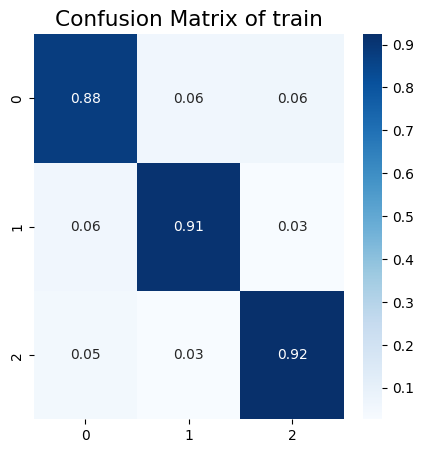

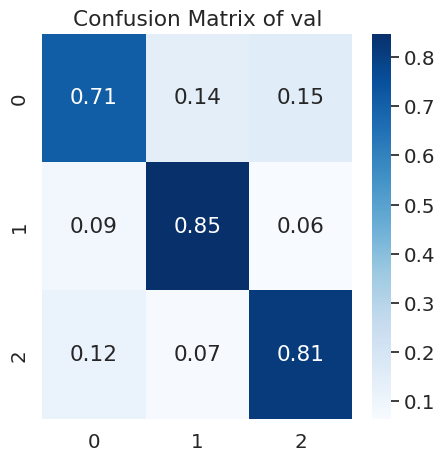

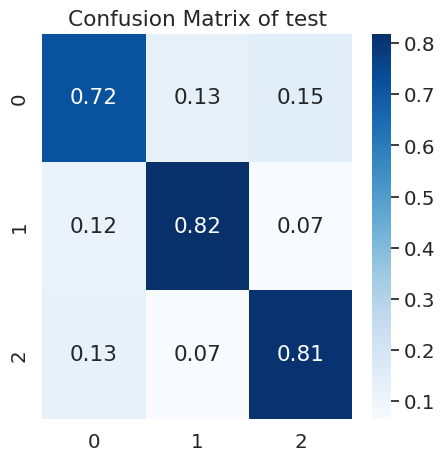

In [34]:
cm_plot(y_train, y_pred_train, 'train')
cm_plot(y_val, y_pred_val, 'val')
cm_plot(y_test, y_pred_test, 'test')

In [35]:
statistic(y_pred_test, y_test, y_pred_train, y_train, 'train', 'test')

,train,test
balanced_accuracy_score,0.903842,0.781611
accuracy_score,0.903842,0.781591
f1 weighted,0.903757,0.78113
f1 micro,0.903842,0.781591
f1 macro,0.903757,0.781144


In [36]:
statistic(y_pred_train, y_train, y_pred_val, y_val, 'dev', 'train')

,dev,train
balanced_accuracy_score,0.789749,0.903842
accuracy_score,0.789782,0.903842
f1 weighted,0.788668,0.903757
f1 micro,0.789782,0.903842
f1 macro,0.788648,0.903757


In [37]:
from google.colab import files
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [38]:
!cp second_robert_sentiment_0.78975.bin xxx